# Face synthesis with GANs in PyTorch (and Keras)
**Nishant Prabhu, 2 August 2020**

This notebook runs the trained model to generate images of some random faces. Also, in the latter section, we will explore the inner workings of the generator by investigating the latent space.

In [5]:
# Dependencies

import torch
import time
import random
import pickle
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

We must define the generator as we did in the main script here. We will initialize a new model and load the weights of the trained model into it.

In [3]:
# Generator class to load weights into 

class Generator(torch.nn.Module):

    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.fc_1 = torch.nn.Linear(latent_dim, 16*4*4)
        self.conv_trans_1 = torch.nn.ConvTranspose2d(
            16, 32, stride=(2, 2), kernel_size=(4, 4), padding=(1, 1)
        )
        self.conv_trans_2 = torch.nn.ConvTranspose2d(
            32, 64, stride=(2, 2), kernel_size=(4, 4), padding=(1, 1)
        )
        self.conv_trans_3 = torch.nn.ConvTranspose2d(
            64, 128, stride=(2, 2), kernel_size=(4, 4), padding=(1, 1)
        )
        self.conv_trans_4 = torch.nn.ConvTranspose2d(
            128, 128, stride=(2, 2), kernel_size=(4, 4), padding=(1, 1)
        )
        self.conv = torch.nn.Conv2d(
            128, 1, stride=(1, 1), kernel_size=(1, 1)
        )

    def forward(self, x):
        # Input shape : (batch_size, latent_dim)

        x = self.fc_1(x)
        x = F.leaky_relu(x, 0.2)
        x = torch.reshape(x, (-1, 16, 4, 4))
        x = self.conv_trans_1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv_trans_2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv_trans_3(x)
        x = F.leaky_relu(x)
        x = self.conv_trans_4(x)
        x = F.leaky_relu(x)
        x = self.conv(x)
        x = torch.tanh(x)

        return x

Below, I've created the trained model, and used a random bunch of latent vectors to generate 64 images of people's faces. Since our model is very simple, most faces look slightly to very disfigured. Even so, it seems to have done a decent job.

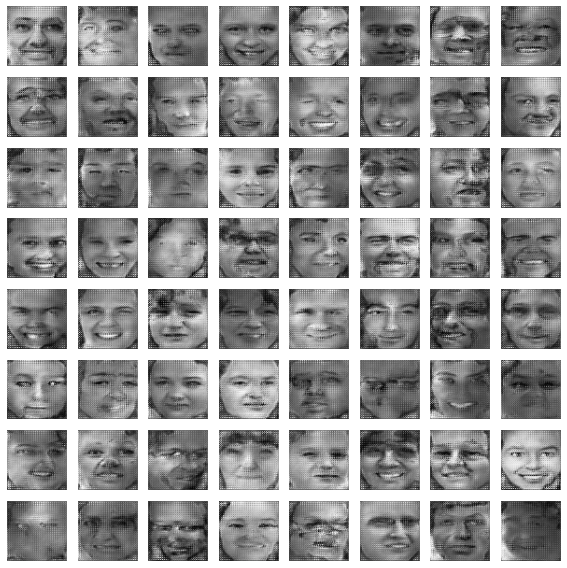

In [32]:
# Create a new generator object and load the saved weights

model = Generator(latent_dim=200)
model.load_state_dict(torch.load("../../saved_data/generator_96", map_location=torch.device("cpu")))

# Generate latent samples (64)

latent_ = np.random.normal(loc=0, scale=1, size=(64, 200))
latent_ = torch.FloatTensor(latent_)

# Generate corresponding images using generator

images = model(latent_)
images = images.cpu().detach().numpy()
images = (images + 1.0) / 2.0

# Show the images in a grid
fig = plt.figure(figsize=(8, 8))

for i in range(images.shape[0]):
    fig.add_subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(0), cmap='gray')

plt.tight_layout()
plt.show()

## Exploring the latent space
The generator has learn a function to map the latent space to the images that we see above. What information does the latent space give it? Let's find out. From the images above, I've picked out the latent vectors corresponding to three, which will help me demonstrate my point.
1. Image of man at (4, 6), smiling to some extent
2. Image of a person at (1, 4), who also seems to be smiling
3. Image of another person at (5, 3), who looks slightly worried

We now perform this vectorial operation, to get another vector in the same space.

```
final = person 1 - person 2 + person 3
```

Then, I'll generate the image corresponding to this latent vector. Let's see what we get. 

In [46]:
person_1 = latent_[29]
person_2 = latent_[3]
person_3 = latent_[34]

final = person_1 - person_2 + person_3

RESULT:


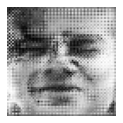

In [48]:
# Generate the corresponding image

image = model(final.unsqueeze(0))
image = image.cpu().detach().numpy()

print("RESULT:")
plt.figure(figsize=(2, 2))
plt.imshow(image[0].squeeze(0), cmap='gray')
plt.axis("off")
plt.show()

**Did you see that?** Here's what has happened:
1. The person in the new image isn't smiling anymore, since we subtracted person 2 from person 1. In fact, he has inherited the worried expression of person 3, which we added.
2. This new person has some hair hanging on the top left, similar to how person 3 has their hair.

This tells us that each dimension in the latent space carries information about some feature of the face: smile, gender, hair, skin tone, etc. When this is modified in the latent space, the generated image reflects those modifications too. Cool!